# Comparing Groups

In [2]:
import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats as stats

import arviz as az
import pymc as pm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

## Transactions from Blockchain

### Data

In [10]:
import pickle as pk

path = 'drive/MyDrive/DATA/'
file_name = 'data_sharks.pickle'

with open(path+file_name, 'rb') as f:
    data = pk.load(f)

data.keys()

dict_keys(['hammerhead', 'mako', 'tiger_shark', 'great_white', 'megalodon'])

### EDA

In [11]:
outs_len = {key:[len(i) for i in data[key]['outs']] for key in data.keys()}
inps_len = {key:[len(i) for i in data[key]['inputs']] for key in data.keys()}

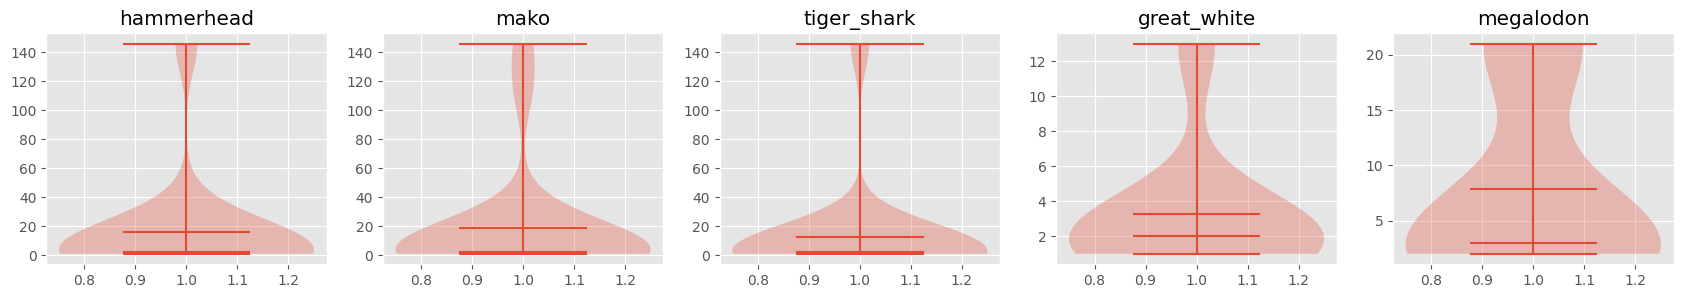

In [12]:
fit, axs = plt.subplots(1, len(outs_len.keys()), figsize=(21, 3))

for i, shark in enumerate(outs_len.keys()):
    axs[i].violinplot(outs_len[shark], showmeans=True, showmedians=True)
    axs[i].set_title(shark)


### Model

In [13]:
outs = np.array([x for xs in list(outs_len.values()) for x in xs])
categories_o = np.array(list(data.keys()))
idx_o = pd.Categorical([key for key, val in outs_len.items() for i in val], categories_o).codes
groups_o = len(np.unique(idx_o))

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

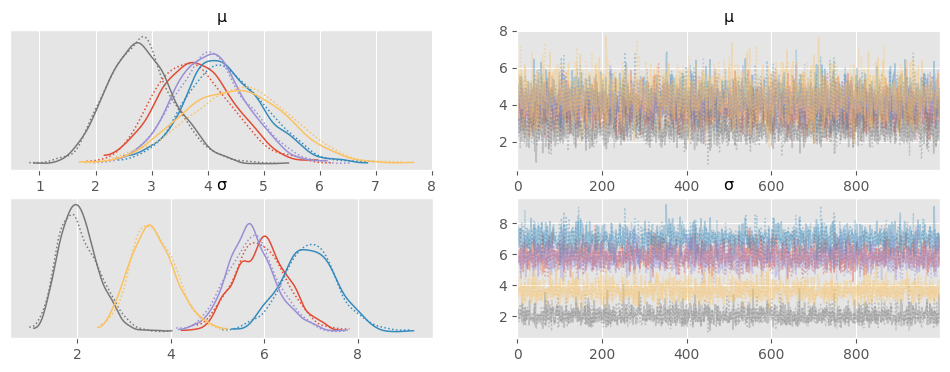

In [15]:
with pm.Model() as comparing_outs:
    μ = pm.HalfNormal('μ', sigma=5, shape=groups_o)
    σ = pm.HalfNormal('σ', sigma=1, shape=groups_o)

    y = pm.Gamma('y', mu=μ[idx_o], sigma=σ[idx_o], observed=outs)

    idata_o = pm.sample()

az.plot_trace(idata_o)

## Close Prices

### Data

In [3]:
url = 'https://github.com/fadeeva/stock_market_research/raw/refs/heads/master/data/AAPL_IBM_MCD_2021-01-01_2022-12-31_1d.csv'
df = pd.read_csv(url, header=[0, 1], parse_dates=True, index_col=0)
df.head()

Close                         Dividends            \
                  AAPL         IBM         MCD      AAPL  IBM  MCD   
Date                                                                 
2021-01-04  127.331688  103.558609  197.740234       0.0  0.0  0.0   
2021-01-05  128.905975  105.396835  198.925400       0.0  0.0  0.0   
2021-01-06  124.566818  108.028824  198.473923       0.0  0.0  0.0   
2021-01-07  128.817444  107.778152  199.395752       0.0  0.0  0.0   
2021-01-08  129.929260  107.393791  203.054825       0.0  0.0  0.0   

                  High                                 Low  ...              \
                  AAPL         IBM         MCD        AAPL  ...         MCD   
Date                                                        ...               
2021-01-04  131.464233  105.213003  201.973091  124.724245  ...  195.858965   
2021-01-05  129.624262  105.848033  199.367499  126.367408  ...  197.175819   
2021-01-06  128.945356  110.192908  199.141780  124.350350  ...  196.620871   
2021-01-07  129.516048  109.006421  200.562144  125.806589  ...  198.060052   
2021-01-08  130.499947  108.053878  203.289984  128.138483  ...  199.630915   

                  Open                         Stock Splits            \
                  AAPL         IBM         MCD         AAPL  IBM  MCD   
Date                                                                    
2021-01-04  131.375682  105.154518  201.756749          0.0  0.0  0.0   
2021-01-05  126.820027  104.452658  197.702572          0.0  0.0  0.0   
2021-01-06  125.668834  106.031847  198.756116          0.0  0.0  0.0   
2021-01-07  126.298559  108.655483  200.562144          0.0  0.0  0.0   
2021-01-08  130.303147  107.427211  200.261138          0.0  0.0  0.0   

               Volume                    
                 AAPL      IBM      MCD  
Date                                     
2021-01-04  143301900  5417443  4055400  
2021-01-05   97664900  6395872  2576100  
2021-01-06  155088000  8322708  3083400  
2021-01-07  109578200  4714740  3142000  
2021-01-08  105158200  4891305  2639100  

[5 rows x 21 columns]

In [4]:
df = df['Close']

In [5]:
for ticker in df.columns:
    df[f'{ticker}_returns'] = np.log(df[ticker] / df[ticker].shift(1))


In [6]:
df.dropna(axis=0, inplace=True)

### Model

In [7]:
prices_group = []
for ticker in ['AAPL', 'IBM', 'MCD']:
    group = np.repeat(ticker, df.shape[0])
    prices_group.extend(group)


In [8]:
prices = df[['AAPL', 'IBM', 'MCD']].values.flatten('F')
categories = np.array(['AAPL', 'IBM', 'MCD'])
idx = pd.Categorical(prices_group, categories).codes
groups = len(np.unique(idx))

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

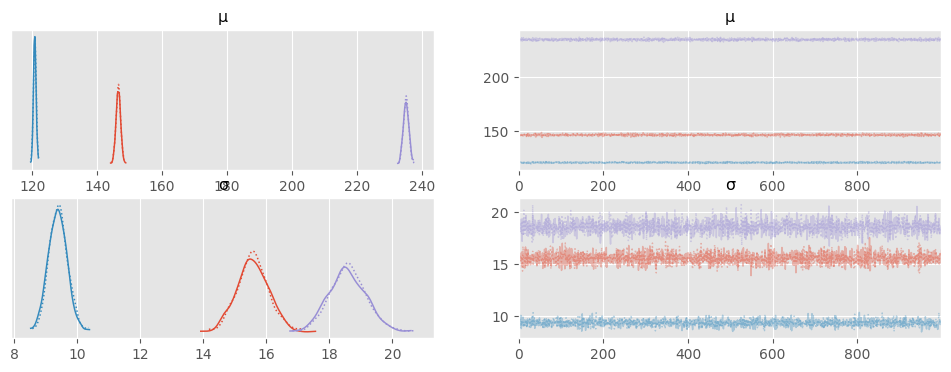

In [9]:
with pm.Model() as comparing_prices:
    μ = pm.HalfNormal('μ', sigma=100, shape=groups)
    σ = pm.HalfNormal('σ', sigma=100, shape=groups)

    y = pm.Gamma('y', mu=μ[idx], sigma=σ[idx], observed=prices)

    idata_cg = pm.sample()

az.plot_trace(idata_cg)